
# IS OUR UNIVERSE FLAT? 

The aim of this experiment is to determine constraints on the values of cosmological parameters by statistical analysis of the “Hubble diagram” for a sample of type Ia supernovae. This analysis is one of the key pieces of evidence in favour of a non-zero “cosmological constant” or “dark energy”, which leads to an acceleration of the expansion of the universe. 

A plot of redshift z against distance or brightness of a population of objects is known as the Hubble diagram. 
In the local universe, for low values of redshift, $cz = H_0d$ where the slope of the relation, $H_0$, is known as Hubble’s constant and tells us the current rate of expansion of the universe. 
However, in reality, according to the standard cosmological model this quantity varies with cosmological epoch, and hence the redshift of the objects being used to measure it. So we refer to the redshift-dependent quantity as the Hubble parameter, H(z). The manner in which H(z) varies with redshift depends on the geometry and expansion history of the universe, so in principle by measuring the Hubble diagram at high redshifts we can learn something about what our universe is made of. 
Nowadays we can probe to much larger redshifts and distances than Hubble could, the aim of this practical is to investigate one of the most important datasets currently available to cosmologists.


**What do we need?** 

- Some python modules broadly used in physics: 

SCIPY: https://scipy.org

ASTROPY: https://www.astropy.org
In particular, we will use the astropy.cosmology sub-package that has a lot of cosmological utility functions (https://docs.astropy.org/en/stable/cosmology/index.html) which contains classes for representing cosmologies and utility functions for calculating commonly used quantities...

EMCEE: https://emcee.readthedocs.io/en/stable/ 
To find the combination of parameters of a cosmological model that would give the best fit for our observed data, we need to search a large parameter space. Of course, we could just create an array of combinations of parameters and check one by one how they fit and pick the best one, but that would take a lot of time and there are much more computationally feasible methods of sampling the parameter space. One such method makes use of the Markov chain Monte Carlo (MCMC) algorithyms and is implemented in the emcee Python package which we will use here. 

- The csv file we have already used before
You can download it from here: 
https://drive.google.com/file/d/1kcIlPfmhAoBVOj7ftpiN10Ie95aejoJT/view?usp=sharing


**Exploring the code**

It is important to not treat the used code like a "blackbox", that takes the given input and produces an output, without concerning ourselves of what is happening inside, but to understand it and identify vital points where something could go wrong. The main code that we will be using during this practical is explained below. 

Look at the flow-chart and try to identify in the code, which lines exactly are responsible for the actions described in it.
The flow-chart of the code is as follows:

1. The values of observed redshift, magnitude, extinction and their errors are read from the datatable and saved in adequate arrays.

2. The emcee sampler is set up, by defining the number of steps, walkers and dimension of the parameters space and defining the initial parameter values. (The sampler releases "walkers" (nwalkers in the code) into the parameter space. Each of the walkers starts near the area specified by the zpt coordinates and starts wandering, looking for the point in the parameter space for which the calculated log_likelihood is the greatest, i.e. where the agreement between the modelled and measured values is best. Then, they wander around those maximum likelihood values exploring the full posterior distribution, unitil they all make the number of steps, specified by the nsteps constant. After the sampler finishes, we can call the results using the sampler.get_chain() function, which returns an array with the shape (nsteps, nwalkers, ndim) giving the parameter values for each walker at each step in the chain. And that is essentially what we can see on the corner plot (see below) - each dot marks the point at which one of the walkers has landed. (To better see how exactly the walkers have been wandering, you might want to plot the positions of each walker as a function of the number of steps in the chain).

3. The ecmcee sampler is started and calls the log_likelihood, log_prior, log_probability and model_magnitude functions for each iteration: 
- model_values function calculates for the observed redshifts and extinctions of the Supernovas, what the observed magnitude would be for a given cosmology model. 
- log_likelihood function calculates the probability of a dataset given the model parameters, in other words, it quantifies how well the model magnitude values (calculated for a given cosmology model) fit the observed ones. The most standard likelihood function has Gaussian form. Loglikelihood function has negative values and the higher it is, the better the fit.
- log_prior function gives us the opportunity to state any previous knowledge about the parameters that are being fitted: results from other experiments, physically acceptable ranges (like Om0 > 0) etc, for any value that is outside of the given constraints, log_prior function will return log probability of minus infinity, essentially informing the sampler that these values are impossible.
- log_probability function simply joins the probabilities given by log_prior and log_likelihood functions

4. Finally, the results are displayed in the corner plot using the corner.corner() function (https://corner.readthedocs.io/en/latest/api/).


# PREPARING TO GO...


In [5]:
# Here we are just preparing the "environment" by importing modules we will need
import scipy
import astropy
import emcee
from astropy.cosmology import wCDM
from astropy.cosmology import LambdaCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import WMAP9
import math
import corner
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii

In [6]:
# Here we read the "csv" file with the data. Make sure you adjust the path to the right one...
path='/Users/adityanaik/Desktop/' # needs to be adjusted
data = ascii.read(path+'SNLS.csv',format='basic') 
flux = np.array(data['MeasuredFlux'])
flux_err = np.array(data['ErrorMeasuredFlux']) 
log_z=np.array(data['log_z'])
redshift = np.array(data['Redshift'])
extinction = np.array(data['extinction'])

#Now, we are ready to create some plots...  and discover if our Universe is flat!!!


# The Hubble diagram

Let's start by plotting the redshift (in log units!) against the apparent magnitude (brightness) of our SNa. This is known as the Hubble diagram. 

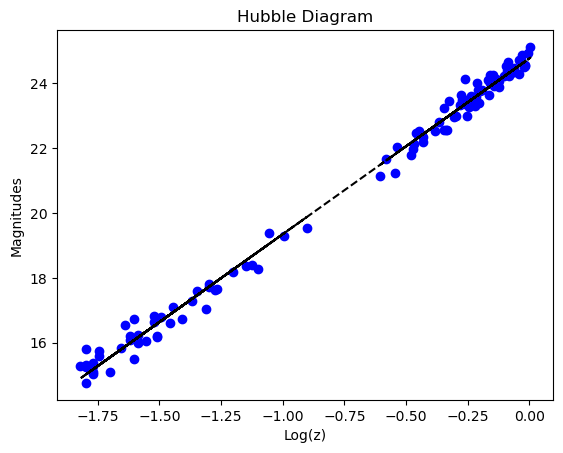

In [7]:
x = log_z
y = flux

# and then we fit a line
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, 'bo', x, m*x+b, '--k')
plt.title('Hubble Diagram')
plt.xlabel('Log(z)')
plt.ylabel('Magnitudes')
plt.show()

**What is the slope of the relation you find?**

**Can we find a way to bring it back to 5?**

**What does this tell us about the Universe?**

# Flat universe models and emcee


We consider a ***flat*** universe with a possible non-zero cosmological constant, where w=-1 and $Ω_{M,0}+Ω_{Λ,0}=Ω_{tot,0}=1$, therefore all we need to fit for is $Ω_{M,0}$ and absolute magnitude and use the astropy.cosmology.FlatLambdaCDM(H0=H0, Om0=Om0) function. And that is what the code below does.


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 86.73it/s]


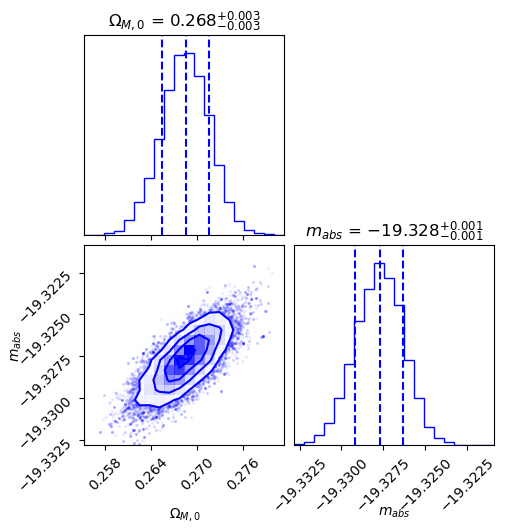

In [8]:
# Here we set the input parameters and define our cosmological model.

def model_magnitude(redshift, Om0, abs_mag):
    H0 = 70
    cosmo = astropy.cosmology.FlatLambdaCDM(H0=H0, Om0=Om0)
    com_dist = cosmo.comoving_distance(redshift)
    lum_dist = (1+redshift)*com_dist.value
    obs_mag = abs_mag + 5*(np.log10(np.array(lum_dist*1000000))) - 5 + extinction
    return obs_mag

def log_likelihood(theta, redshift, flux, flux_err):
    Om0, abs_mag = theta
    modell = model_magnitude(redshift, Om0, abs_mag)
    sigma2 = flux_err**2  
    return np.sum(-(flux - modell) ** 2 / (2*sigma2) + np.log(1/np.sqrt(sigma2*2*np.pi)))

def log_prior(theta):
    Om0, abs_mag = theta
    if 0< Om0 < 1 and -22< abs_mag <-17:
        return 0.0
    return -np.inf

def log_probability(theta, redshift, flux, flux_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, redshift, flux, flux_err)

# Finally, we are ready to set the EMCEE
nwalkers, ndim, nsteps = 24, 2, 1000
sampler = emcee.EnsembleSampler( nwalkers, ndim, log_probability, args=(redshift, flux, flux_err) )
zpt = [0.27,-19.33]
p0  = [zpt+1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(p0, nsteps, progress=True);

flat_samples = sampler.get_chain(discard=100,flat=True)
labels = [r'$Ω_{M,0}$',r'$m_{abs}$']
fig = corner.corner(flat_samples, labels=labels,quantiles=[0.16, 0.5, 0.84], show_titles=True, color='blue',title_fmt='.3f')


**What are the best-fitted values and their errors?**


It is always a good practice to check how the magnitudes caculated for the best fitting model compare to the observed ones (if they are completely off, that is a sign that somethnig probably went wrong).

We therefore produce below a scatter plot the redshift vs the observed magnitudes with errors (note that they might be very small) and the calculated magnitudes for the best fitting model that emcee has found. 


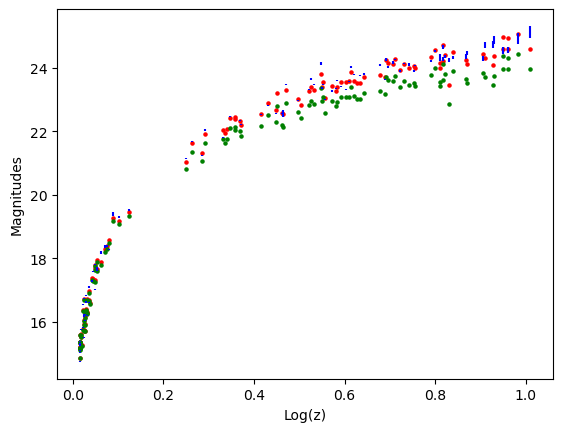

In [9]:
def model_magnitude(redshift, Om0, abs_mag):
    H0 = 70
    cosmo = astropy.cosmology.FlatLambdaCDM(H0=H0, Om0=Om0)
    com_dist = cosmo.comoving_distance(redshift)
    lum_dist = (1+redshift)*com_dist.value
    obs_mag = abs_mag + 5*(np.log10(np.array(lum_dist*1000000))) - 5 +extinction
    return obs_mag

fig2=plt.errorbar(redshift,flux,yerr=flux_err,xerr=np.zeros(len(flux)),c='blue',ls='None')
plt.scatter(redshift,model_magnitude(redshift, 0.268, -19.328),s=5,c='red')
plt.scatter(redshift,model_magnitude(redshift, 1, -19.328),s=5,c='green')
plt.xlabel('Log(z)')
plt.ylabel('Magnitudes')
red=np.arange(0,1,0.001)

**How do they compare?** 

We can als plot the calculated magnitude for a model that assumes $Ω_{M,0}=1$ (i.e. $Ω_{Λ,0}=0$). 

**How do they compare to the observed magnitudes? What does it tell us about our universe?**


# Non-flat universe models
After getting more familiar with the code and emcee, we will now consider a non-flat universe model, for which $Ω_{M,0}+Ω_{Λ,0}=1$ is not necessarily true, but $w_{0}=-1$ does hold. We will therefore (additionally to $Ω_{M,0}$ and absolute magnitude) will have to fit for $Ω_{Λ,0}$. To do it, we will have to change the astropy cosmology model used to astropy.cosmology.LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0), which takes also $Ω_{Λ,0}$ as an input and change the code to fit for one more variable.

**Adjust the code to additionally fit for $Ω_{Λ,0}$ and produce new corner plot and scatter plots. You will have to "guess" the initial value of $Ω_{Λ,0}$, but you can rerun the code again with values closer to the best fit. Remember to adjust the priors accrodingly.**

In [10]:
import scipy
import astropy
import emcee
from astropy.cosmology import wCDM
from astropy.cosmology import LambdaCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import WMAP9
import math
import corner
import numpy as np
from astropy.io import ascii



100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 79.46it/s]


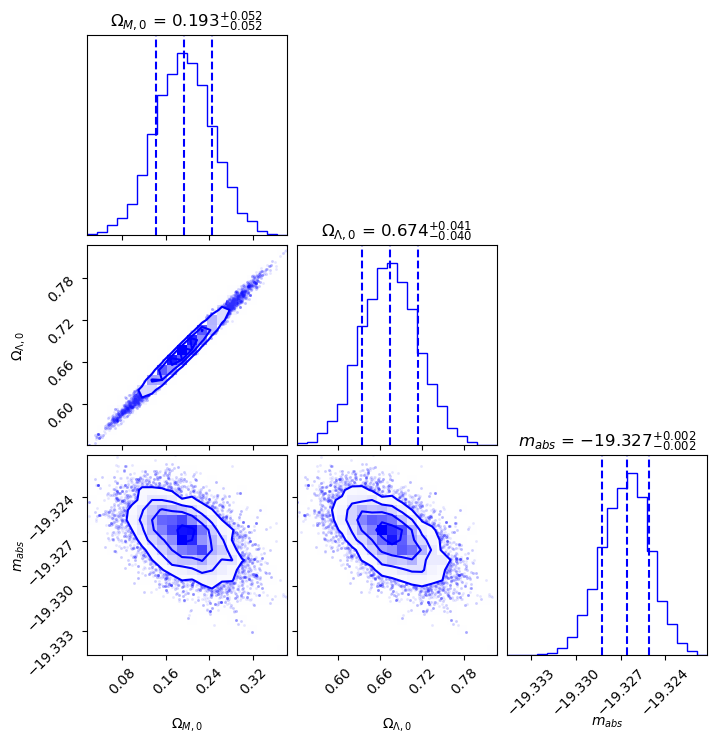

In [11]:
import scipy
import astropy
import emcee
from astropy.cosmology import wCDM
from astropy.cosmology import LambdaCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import WMAP9
import math
import corner
import numpy as np
from astropy.io import ascii


data = ascii.read(path+'SNLS.csv',format='basic') 
flux = np.array(data['MeasuredFlux']) # needs to be adjusted
flux_err = np.array(data['ErrorMeasuredFlux']) # needs to be adjusted
redshift = np.array(data['Redshift']) # needs to be adjusted
extinction = np.array(data['extinction'])


def model_magnitude(redshift, Om0, Ode0, abs_mag):
    H0 = 70
    cosmo = astropy.cosmology.LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    com_dist = cosmo.comoving_distance(redshift)
    lum_dist = (1+redshift)*com_dist.value
    obs_mag = abs_mag + 5*(np.log10(np.array(lum_dist*1000000))) - 5 + extinction
    return obs_mag

def log_likelihood(theta, redshift, flux, flux_err):
    Om0, Ode0, abs_mag = theta
    modell = model_magnitude(redshift, Om0, Ode0, abs_mag)
    sigma2 = flux_err**2  
    return np.sum(-(flux - modell) ** 2 / (2*sigma2) + np.log(1/np.sqrt(sigma2*2*np.pi)))

def log_prior(theta):
    Om0, Ode0, abs_mag = theta
    if 0< Om0 < 2 and 0< Ode0 < 1 and -23< abs_mag <-17:
        return 0.0
    return -np.inf

def log_probability(theta, redshift, flux, flux_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, redshift, flux, flux_err)

nwalkers, ndim, nsteps = 24, 3, 1000
sampler = emcee.EnsembleSampler( nwalkers, ndim, log_probability, args=(redshift, flux, flux_err) )
zpt = [0.20, 0.70,-19.33]
p0  = [zpt+1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(p0, nsteps, progress=True);

flat_samples = sampler.get_chain(discard=100,flat=True)
labels = [r'$Ω_{M,0}$',r'$Ω_{Λ,0}$',r'$m_{abs}$']
fig = corner.corner(flat_samples, labels=labels,quantiles=[0.16, 0.5, 0.84], show_titles=True, color='blue',title_fmt='.3f')

**What are the new best-fit parameter values?** 

**What can you infer from the value of $Ω_{M,0}+Ω_{Λ,0}$ about our Universe?** 





# Dark energy models in a flat Universe
Next, we will explore dark energy models for which we will assume $Ω_{M,0}+Ω_{Λ,0}=1$ (coming back to the flat case!), but $w_{0}=-1$ is not necessarily true. We will therefore have to fit for $w_{0}$, rather than $Ω_{Λ,0}$ and use the astropy.cosmology.FlatwCDM(H0=H0, Om0=Om0, w0=w0) function. 

(Note: we have adjusted the code to fit for $w_{0}$, if you want, try to identify where we did that!)

100%|███████████████████████████████████████| 2000/2000 [01:06<00:00, 29.93it/s]


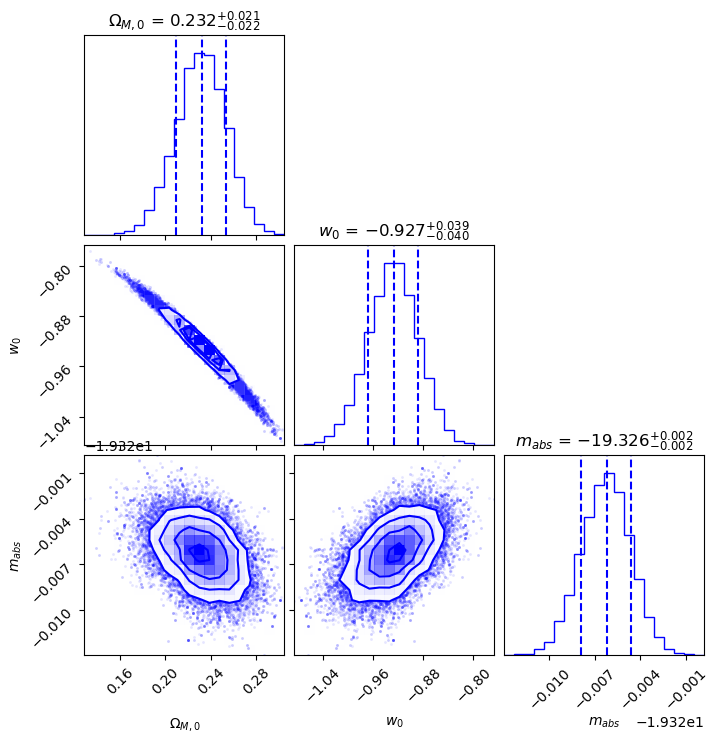

In [12]:
import scipy
import astropy
import emcee
from astropy.cosmology import FlatwCDM
from astropy.cosmology import LambdaCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import WMAP9
import math
import corner
import numpy as np
from astropy.io import ascii



data = ascii.read(path+'SNLS.csv',format='basic') 
flux = np.array(data['MeasuredFlux']) 
flux_err = np.array(data['ErrorMeasuredFlux']) 
redshift = np.array(data['Redshift']) 
extinction = np.array(data['extinction'])


def model_magnitude(redshift, Om0, w0, abs_mag):
    H0 = 70
    cosmo = astropy.cosmology.FlatwCDM(H0=H0, Om0=Om0, w0=w0)
    com_dist = cosmo.comoving_distance(redshift)
    lum_dist = (1+redshift)*com_dist.value
    obs_mag = abs_mag + 5*(np.log10(np.array(lum_dist*1000000))) - 5 + extinction
    return obs_mag

def log_likelihood(theta, redshift, flux, flux_err):
    Om0, w0, abs_mag = theta
    modell = model_magnitude(redshift, Om0, w0, abs_mag)
    sigma2 = flux_err**2  
    return np.sum(-(flux - modell) ** 2 / (2*sigma2) + np.log(1/np.sqrt(sigma2*2*np.pi)))

def log_prior(theta):
    Om0, w0, abs_mag = theta
    if 0< Om0 < 1 and -2< w0 < -0.5 and -22< abs_mag <-17:
        return 0.0
    return -np.inf

def log_probability(theta, redshift, flux, flux_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, redshift, flux, flux_err)

nwalkers, ndim, nsteps = 24, 3, 2000
sampler = emcee.EnsembleSampler( nwalkers, ndim, log_probability, args=(redshift, flux, flux_err))
zpt = [0.2, -1,-19.33]
p0  = [zpt+1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(p0, nsteps, progress=True);

flat_samples = sampler.get_chain(discard=100,flat=True)
labels = [r'$Ω_{M,0}$',r'$w_{0}$',r'$m_{abs}$']
fig = corner.corner(flat_samples, labels=labels,quantiles=[0.16, 0.5, 0.84], show_titles=True, color='blue',title_fmt='.3f')


# Non-flat dark energy models
In the previous sections we have either assumed $Ω_{M,0}+Ω_{Λ,0}=1$ or $w_{0}=-1$ or both. Now, let's see what happens if we do not assume anything and try to fit for all four parameters. 
To do that, we have adjusted the code and use the astropy.cosmology.wCDM(H0=H0, Om0=Om0, Ode0=Ode0, w0=w0) function as our model.

Notew that this is much more generic than before and we are fitting for more parameters, which however are degenerate between each other. 
Thus, in order to help the sampler to break those degeneracies we have introduced some "external" constraints, give it hints that some values might be slightly more likely than other. 
For instance, we can use the value of $Ω_{k,0}$, which is inferred from the observations of the cosmic microwave background to be equal to $Ω_{k,0}=0.001\pm0.002$ and "punish" those sets of fitted parameters that do not satisfy the $Ω_{M,0}+Ω_{Λ,0}+Ω_{k,0}=1$ relation within the error of $Ω_{k,0}$. 
Do not worry if this is getting too complicated...you will learn all these things if you continue with Astrophysics and Cosmology... but if not (and for now) we have practically redefined our prior in the fitting...
Up until now, our prior was uniform: returning zero for the parameters that are in the specified range and negative infinity for all others. But the prior does not have to be uniform, we can define it in such a way, that it will return higher likelihood values for the sets of parameters that are closer to satisfying our defined equality, if we know that some values are "more likely than others". 
We can use the expression analogous to the one used in the log_likelihood() function, but instead of the difference (obs_mag-model_mag), we should use the difference between observed $Ω_{k,0}$ and $Ω_{k,0}$ inffered from the fitted $Ω_{M,0}$ and $Ω_{Λ,0}$:

log_cmb_constraint $= -(Ω_{k,0} - (1-Ω_{Λ,0}-Ω_{M,0}))^{2} / (2\sigma^{2}) + log(1/\sqrt{\sigma^{2}\pi})$

where $\sigma^{2}$ is the square of the error of $Ω_{k,0}$. 
Then, if we make the prior return the value of log_cmb_constraint instead of just zero, the sets of parameters which are far from satisfying $Ω_{M,0}+Ω_{Λ,0}+Ω_{k,0}=1$ will be heavily punished by the prior returning for them large negative values of the loglikelihood.


100%|███████████████████████████████████████| 5000/5000 [02:45<00:00, 30.19it/s]


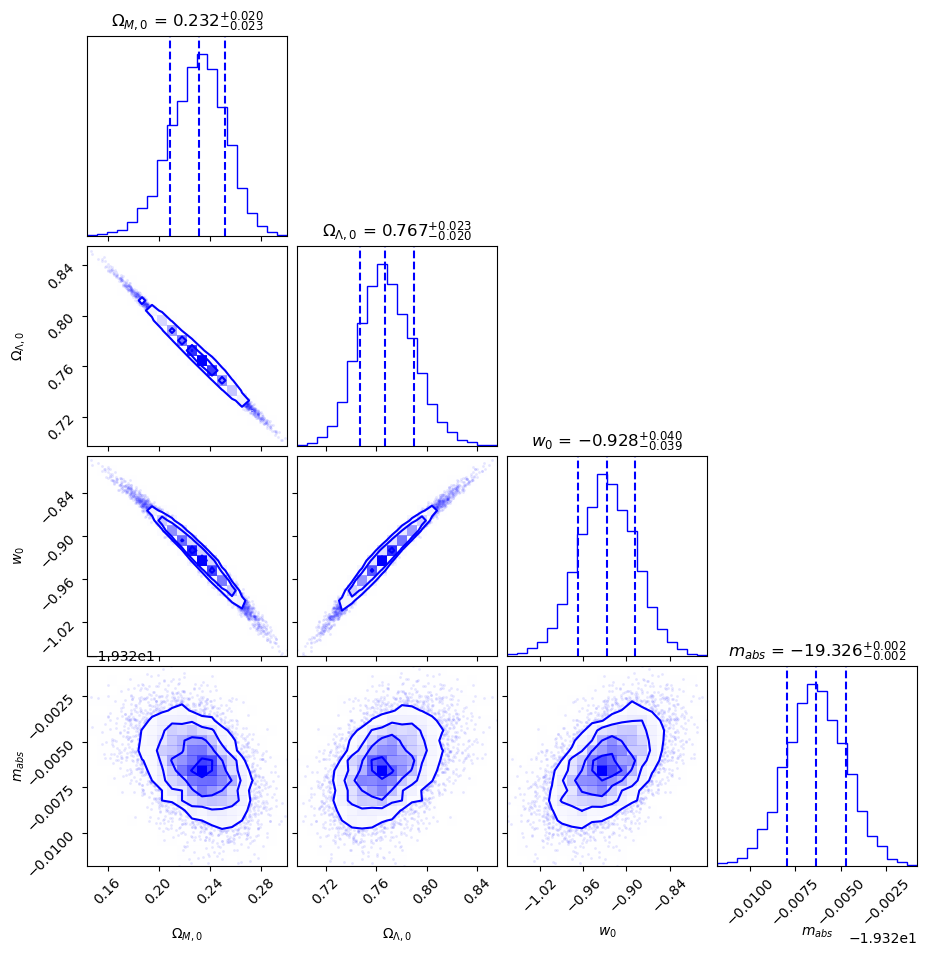

In [13]:
import scipy
import astropy
import emcee
from astropy.cosmology import FlatwCDM
from astropy.cosmology import wCDM
from astropy.cosmology import LambdaCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import WMAP9
import math
import corner
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii


data = ascii.read(path+'SNLS.csv',format='basic') 
obs_mag = np.array(data['MeasuredFlux'])
obs_mag_err = np.array(data['ErrorMeasuredFlux'])
redshift = np.array(data['Redshift'])
extinction =  np.array(data['extinction'])

def model_magnitude(redshift, Om0, Ode0, w0, abs_mag):
    H0 = 70
    cosmo = astropy.cosmology.wCDM(H0=H0, Om0=Om0, Ode0=Ode0, w0=w0)
    com_dist = cosmo.comoving_distance(redshift)
    lum_dist = (1+redshift)*com_dist.value
    model_obs_mag = abs_mag + 5*(np.log10(np.array(lum_dist*1000000))) - 5 + extinction
    return model_obs_mag

def log_likelihood(theta, redshift, obs_mag, obs_mag_err):
    Om0, Ode0, w0, abs_mag = theta
    model_mag = model_magnitude(redshift, Om0, Ode0, w0, abs_mag)
    sigma2 = obs_mag_err**2  
    return np.sum(-(obs_mag - model_mag) ** 2 / (2*sigma2) + np.log(1/np.sqrt(sigma2*2*np.pi)))

def log_prior(theta):
    Ok0 = 0.001
    Ok0_err = 0.002
    sigma2 = Ok0_err**2
    Om0, Ode0, w0, abs_mag = theta
    log_cmb_constraint = (-(Ok0 - (1-Ode0-Om0)) ** 2 / (2*sigma2) + np.log(1/np.sqrt(sigma2*2*np.pi)))
    if 0< Om0 < 2 and 0< Ode0 < 2 and -2< w0 < -0.5 and -22< abs_mag <-17:
        return log_cmb_constraint
    return -np.inf

def log_probability(theta, redshift, obs_mag, obs_mag_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, redshift, obs_mag, obs_mag_err)

nwalkers, ndim, nsteps = 24, 4, 5000
sampler = emcee.EnsembleSampler( nwalkers, ndim, log_probability, args=(redshift, obs_mag, obs_mag_err) )
zpt = [0.23, 0.76, -0.9,-19.33]
p0  = [zpt+1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(p0, nsteps, progress=True);

flat_samples = sampler.get_chain(thin=15,discard=100,flat=True)
labels = [r'$Ω_{M,0}$',r'$Ω_{Λ,0}$',r'$w_{0}$',r'$m_{abs}$']
fig = corner.corner(flat_samples, labels=labels,quantiles=[0.16, 0.5, 0.84], show_titles=True, color='blue',title_fmt='.3f')
